# <center> <span style="font-family: Virgil GS, sans-serif; color:#97f788">XGBoost Regularization Parameters</span> </center>
## <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">Gamma, Alpha, and Lambda</span> </center>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

* **Gamma is a pseudo-regularization hyperparameter in gradient boosting.** Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. 𝛾 can be understood as a control for complexity cost by introducing additional leaf.
* **Alpha** is L1 regularization term on weights. Increasing this value will make model more conservative.
* **Lambda** is L2 regularization term on weights. Increasing this value will make model more conservative.

In [1]:
import numpy as np
import pandas as pd

np.random.seed(0)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Dataset</span>

In [2]:
# Fetch blended credit data
url = (
    "https://drive.google.com/file/d/1LZ7K32OcocobL4jAeeVTC0O4rm0BsT-z/view?usp=sharing"
)
file_id = url.split("/")[-2]
dataset = pd.read_csv(f"https://drive.google.com/uc?id={file_id}")

features = [
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
]

X, y = dataset[features], dataset["is_bad"]

ix_train, ix_test = train_test_split(
    X.index, stratify=y, test_size=0.3, random_state=62
)

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Tree parsing</span>

In [3]:
import xgboost as xgb

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=3,
    max_depth=1,
    random_state=42,
    early_stopping_rounds=3,
    # base_score=0.5
)

evalset = [(X.loc[ix_train], y.loc[ix_train]), (X.loc[ix_test], y.loc[ix_test])]

# Fit the model to the generated dataset
xgb_model.fit(X.loc[ix_train], y.loc[ix_train], eval_set=evalset)

# Make predictions using the model
predictions_trn = xgb_model.predict_proba(X.loc[ix_train])[:, 1]
predictions_tst = xgb_model.predict_proba(X.loc[ix_test])[:, 1]

gini_trn = roc_auc_score(y.loc[ix_train], predictions_trn) * 2 - 1
gini_tst = roc_auc_score(y.loc[ix_test], predictions_tst) * 2 - 1

print(f"Train Gini score: {gini_trn:.2%}\n" f"Test Gini score: {gini_tst:.2%}")

[0]	validation_0-logloss:0.31133	validation_1-logloss:0.31228
[1]	validation_0-logloss:0.29084	validation_1-logloss:0.29218
[2]	validation_0-logloss:0.27597	validation_1-logloss:0.27752
Train Gini score: 73.94%
Test Gini score: 72.49%


In [4]:
import pandas as pd


def extract_leaf_weights(xgb_model: xgb.XGBClassifier):
    booster_ = xgb_model.get_booster()
    tree_df = booster_.trees_to_dataframe()

    # Extract relevant columns for feature gains
    feature_gains = tree_df[tree_df["Feature"] != "Leaf"][
        ["Tree", "ID", "Split", "Yes", "No", "Feature", "Gain"]
    ]

    # Extract relevant columns for leaf gains
    leaf_gains = tree_df[tree_df["Feature"] == "Leaf"][
        ["Tree", "ID", "Split", "Yes", "No", "Feature", "Gain"]
    ]

    # Helper function for merging and renaming
    def merge_and_rename(gains_df, condition_column, sign):
        condition_df = feature_gains.merge(
            gains_df, left_on=condition_column, right_on="ID", how="inner"
        )
        condition_df = condition_df.rename(
            columns={
                "Tree_x": "Tree",
                "Split_x": "Split",
                "Feature_x": "Feature",
                "Gain_y": "XAddEvidence",
            }
        )
        condition_df["Sign"] = sign
        return condition_df[["Tree", "Feature", "Split", "Sign", "XAddEvidence"]]

    # Merge on 'Yes' and 'No' ID (True = Yes, False = No)
    yes_condition_df = merge_and_rename(leaf_gains, "Yes", "<")
    no_condition_df = merge_and_rename(leaf_gains, "No", ">=")

    # Concatenate the DataFrames
    leaf_weights_df = pd.concat([yes_condition_df, no_condition_df], ignore_index=True)
    leaf_weights_df = leaf_weights_df.sort_values(by="Tree").reset_index(drop=True)

    return leaf_weights_df


# Output:
result_df = extract_leaf_weights(xgb_model)
display(result_df[:10])

,Tree,Feature,Split,Sign,XAddEvidence
0,0,account_never_delinq_percent,97.099998,<,0.159356
1,0,account_never_delinq_percent,97.099998,>=,-0.329443
2,1,account_never_delinq_percent,98.000000,<,0.093280
3,1,account_never_delinq_percent,98.000000,>=,-0.314819
4,2,revolving_utilization_of_unsecured_lines,0.581036,<,-0.214555
5,2,revolving_utilization_of_unsecured_lines,0.581036,>=,0.205865


Total number of trees used in estimation: 3


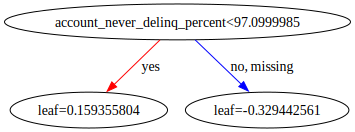

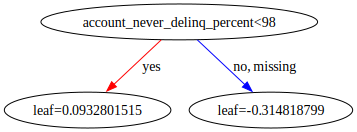

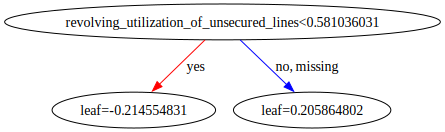

In [5]:
# check how many trees are trained
booster_ = xgb_model.get_booster()
booster_dump = booster_.get_dump()
num_trees_dump = len(booster_dump)
print(f"Total number of trees used in estimation: {num_trees_dump}")

for i in range(num_trees_dump):
    display(xgb.to_graphviz(xgb_model, num_trees=i))

In [6]:
df = extract_leaf_weights(xgb_model)
df

,Tree,Feature,Split,Sign,XAddEvidence
0,0,account_never_delinq_percent,97.099998,<,0.159356
1,0,account_never_delinq_percent,97.099998,>=,-0.329443
2,1,account_never_delinq_percent,98.000000,<,0.093280
3,1,account_never_delinq_percent,98.000000,>=,-0.314819
4,2,revolving_utilization_of_unsecured_lines,0.581036,<,-0.214555
5,2,revolving_utilization_of_unsecured_lines,0.581036,>=,0.205865


In [7]:
df_to_score = X.loc[ix_train].iloc[8:12].copy()
df_to_score["Prediction"] = xgb_model.predict_proba(X.loc[ix_train].iloc[8:12])[:, 1]
df_to_score

,revolving_utilization_of_unsecured_lines,account_never_delinq_percent,Prediction
6957,0.181722,100.0,0.078548
12883,0.344975,94.1,0.172881
17750,0.197036,100.0,0.078548
10397,0.383357,86.7,0.172881


In [121]:
base_score = -1.603428

print(
    1 / (1 + np.exp(-(base_score + -0.329443 + -0.314819 + -0.214555)))
)  # first entry
# 0.07854769484530663
print(1 / (1 + np.exp(-(base_score + 0.159356 + 0.093280 + -0.214555))))  # second entry
# 0.17288072569958252
print(
    1 / (1 + np.exp(-(base_score + -0.329443 + -0.314819 + -0.214555)))
)  # third entry
# 0.07854769484530663
print(1 / (1 + np.exp(-(base_score + 0.159356 + 0.093280 + -0.214555))))  # fourth entry
# 0.17288072569958252

0.07854769484530663
0.17288072569958252
0.07854769484530663
0.17288072569958252


<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Gamma</span>

Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.

𝛾: complexity cost by introducing additional leaf or a pseudo-regularization hyperparameter in gradient boosting

In [145]:
df_leaf_weights_gamma = pd.DataFrame()

for gamma in [0, 10, 20, 50]:
    xgb_model = xgb.XGBClassifier(
        n_estimators=20,
        gamma=gamma,
        random_state=42,
    )
    xgb_model.fit(X.loc[ix_train], y.loc[ix_train])

    df_leaf_weights = extract_leaf_weights(xgb_model)
    df_leaf_weights["Gamma"] = gamma
    df_leaf_weights_gamma = pd.concat(
        [df_leaf_weights_gamma, df_leaf_weights], ignore_index=True
    )

/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


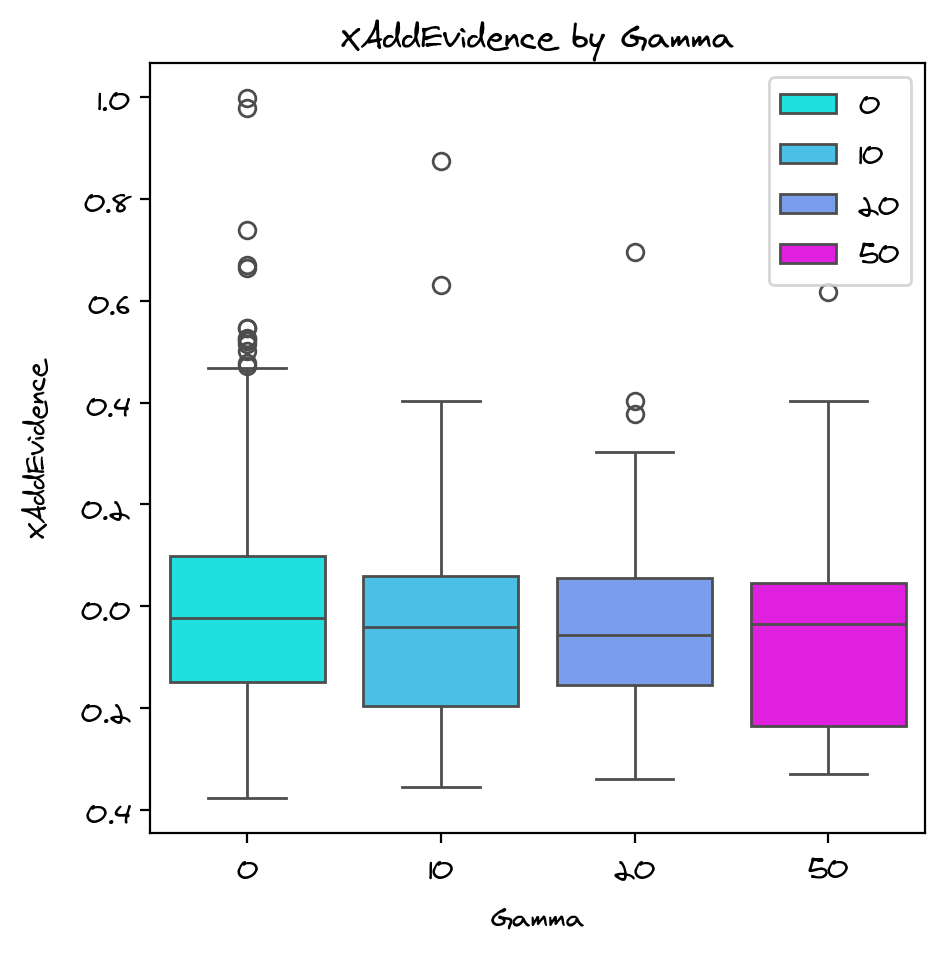

In [146]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Virgil GS"
%config InlineBackend.figure_format = 'retina'

# Create a boxplot to visualize feature gain distribution across Gamma values
plt.figure(figsize=(5, 5))
sns.boxplot(
    data=df_leaf_weights_gamma, x="Gamma", y="XAddEvidence", palette="cool", hue="Gamma"
)
plt.xlabel("Gamma")
plt.ylabel("XAddEvidence")
plt.title("XAddEvidence by Gamma")
plt.legend(loc="upper right")
plt.show()

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_61350/852195970.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text().replace('_', '\n') for label in xticklabels], horizontalalignment='center')
/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


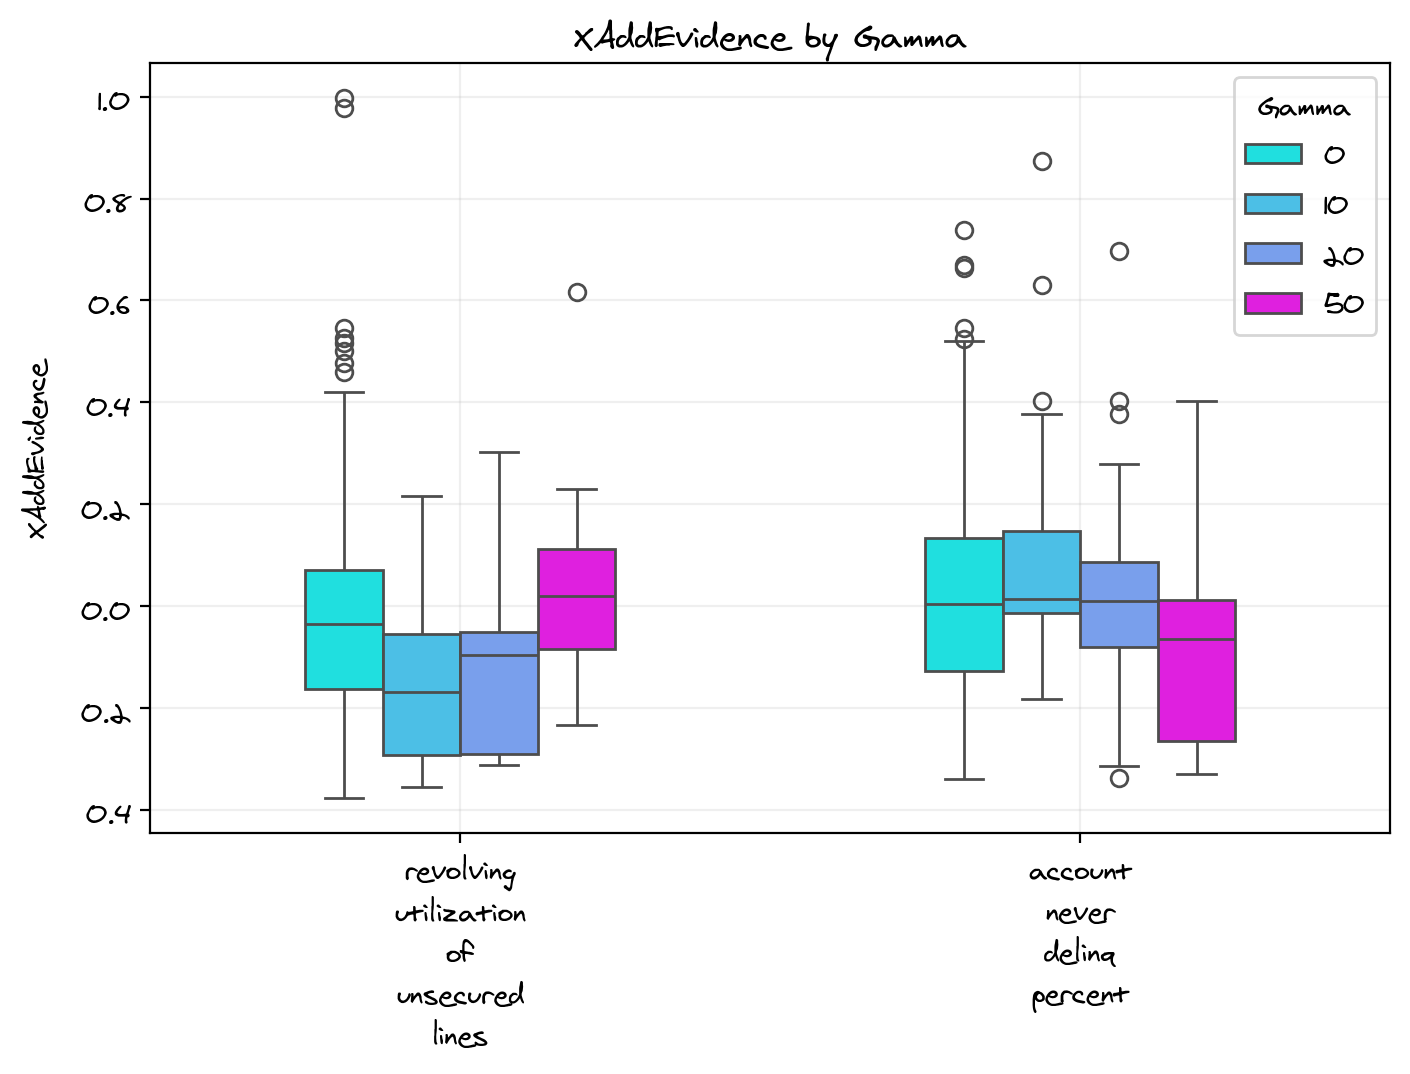

In [162]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Virgil GS"
%config InlineBackend.figure_format = 'retina'

# Create a boxplot to visualize feature gain distribution across Gamma values
plt.figure(figsize=(8, 5), dpi=100)
ax = sns.boxplot(
    data=df_leaf_weights_gamma,
    x="Feature",
    y="XAddEvidence",
    width=0.5,
    palette="cool",
    hue="Gamma",
)
plt.ylabel("XAddEvidence")
plt.xlabel(None)
plt.title("XAddEvidence by Gamma")
plt.legend(title="Gamma", loc="upper right")
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(
    [label.get_text().replace("_", "\n") for label in xticklabels],
    horizontalalignment="center",
)
plt.grid(alpha=0.2)
plt.show()

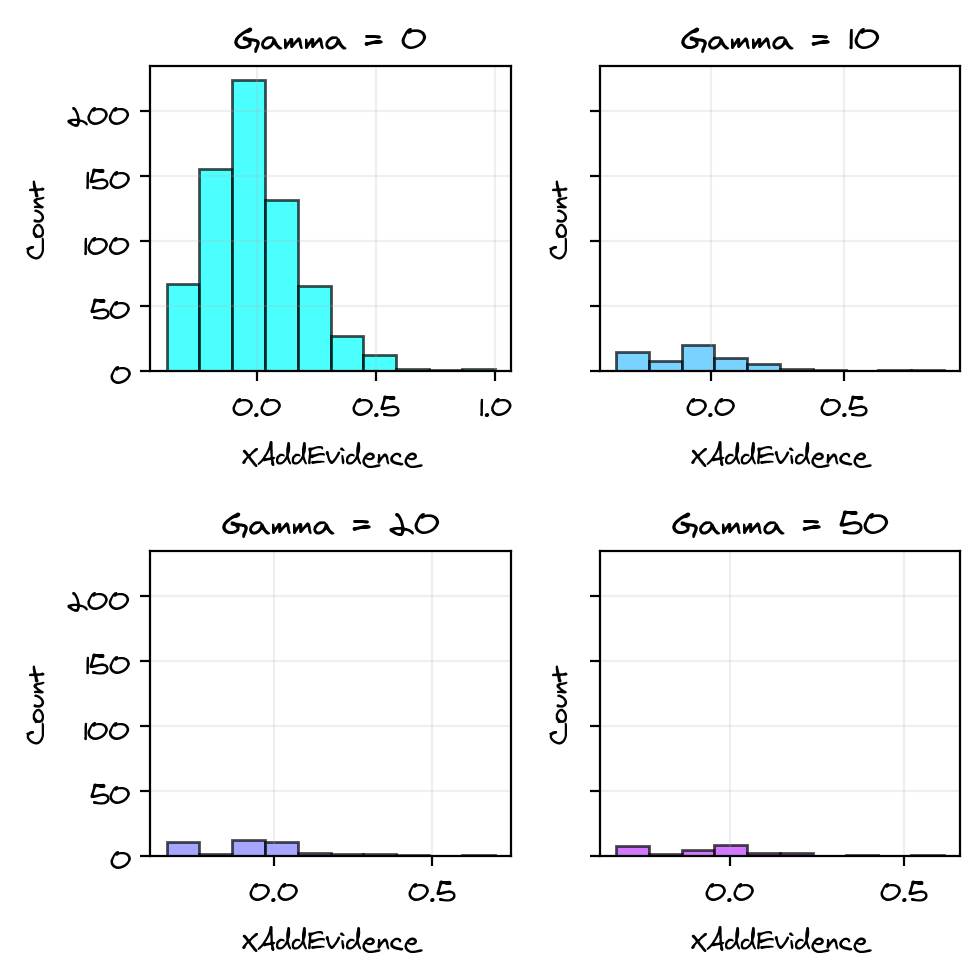

In [163]:
from matplotlib import pyplot as plt
import numpy as np

# Set the number of columns and rows for subplots
num_cols = 2
num_rows = int(np.ceil(len(df_leaf_weights_gamma["Gamma"].unique()) / num_cols))

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5), sharey=True)

# Flatten the axes array to handle both 1-row and multi-row cases
axes = np.array(axes).flatten()

for i, (gamma_value, group) in enumerate(df_leaf_weights_gamma.groupby("Gamma")):
    ax = axes[i]
    ax.hist(
        group["XAddEvidence"],
        color=plt.get_cmap("cool")(i / len(df_leaf_weights_gamma["Gamma"].unique())),  # type: ignore
        alpha=0.7,
        bins=10,
        cumulative=False,
        rwidth=1.1,
        histtype="bar",
        edgecolor="black",
        # orientation='horizontal'
    )
    ax.set_title(f"Gamma = {gamma_value}")
    ax.set_xlabel("XAddEvidence")
    ax.set_ylabel("Count")
    ax.grid(True, linestyle="-", alpha=0.2)

plt.tight_layout()
plt.show()

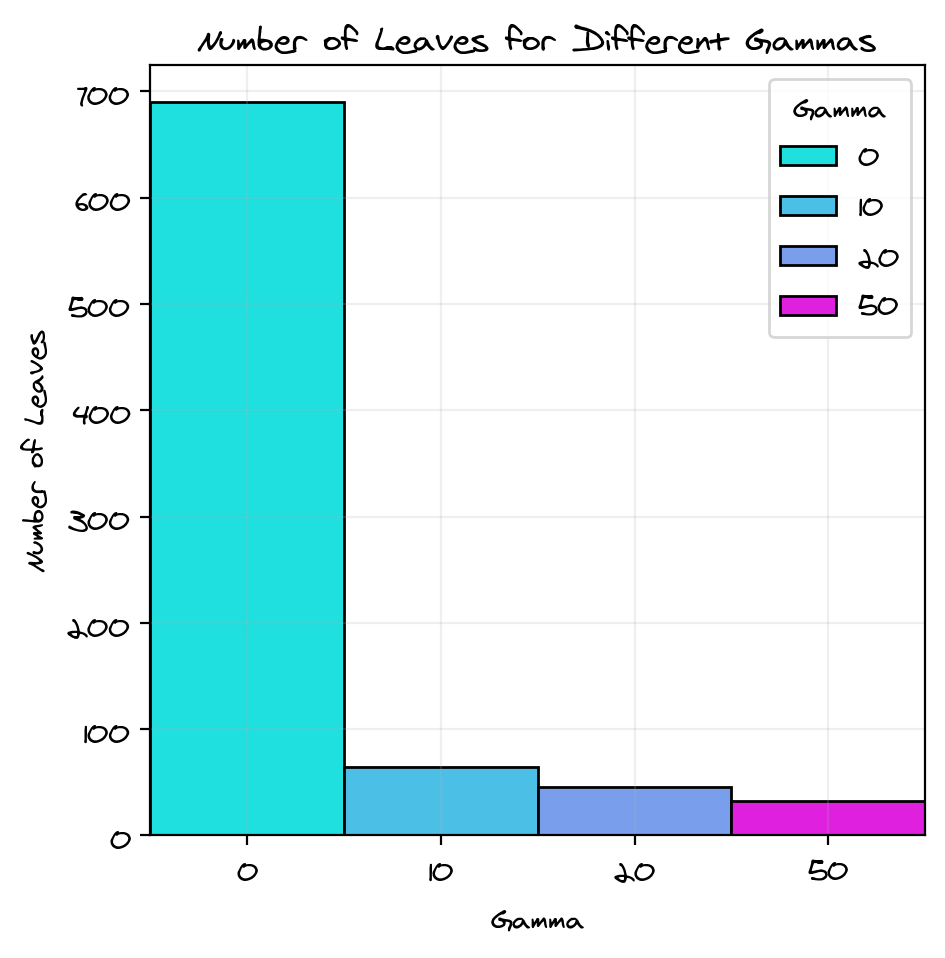

In [167]:
import seaborn as sns
from matplotlib import pyplot as plt

# Grouping the data by 'Gamma' and counting the occurrences of 'Leaf'
leaf_count = df_leaf_weights_gamma.groupby("Gamma")["Feature"].count().reset_index()

figure = plt.figure(figsize=(5, 5), dpi=100)
# Plotting the count of leaves for each 'Gamma'
sns.barplot(
    data=leaf_count,
    x="Gamma",
    y="Feature",
    palette="cool",
    hue="Gamma",
    edgecolor="black",
    width=1.0,
)
plt.xlabel("Gamma")
plt.ylabel("Number of Leaves")
plt.title("Number of Leaves for Different Gammas")
plt.grid(alpha=0.2)
plt.show()

In [181]:
df_leaf_weights_gamma.groupby(["Gamma"]).agg({"Tree": "count"}).reset_index()

,Gamma,Tree
0,0,690
1,10,64
2,20,46
3,50,32


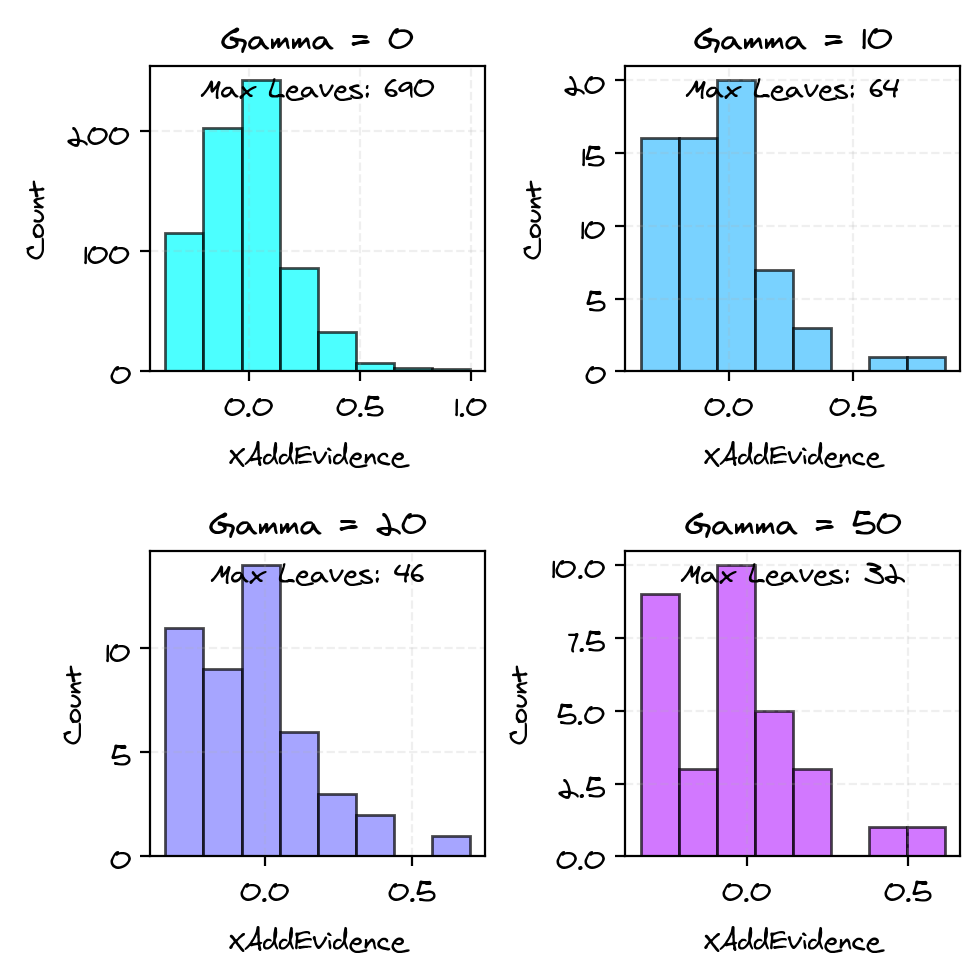

In [183]:
from matplotlib import pyplot as plt
import numpy as np

# Grouping the data by 'Gamma' and counting the occurrences of 'Feature'
leaf_count = df_leaf_weights_gamma.groupby("Gamma")["Feature"].count().reset_index()

# Set the number of columns and rows for subplots
num_cols = 2
num_rows = int(np.ceil(len(df_leaf_weights_gamma["Gamma"].unique()) / num_cols))

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5), sharex=False, dpi=100)

# Flatten the axes array to handle both 1-row and multi-row cases
axes = np.array(axes).flatten()

for i, (gamma_value, group) in enumerate(df_leaf_weights_gamma.groupby("Gamma")):
    ax = axes[i]
    ax.hist(
        group["XAddEvidence"],
        color=plt.get_cmap("cool")(i / len(df_leaf_weights_gamma["Gamma"].unique())),  # type: ignore
        alpha=0.7,
        bins=8,
        cumulative=False,
        rwidth=1.1,
        histtype="bar",
        edgecolor="black",
        # orientation='horizontal'
    )
    ax.set_title(f"Gamma = {gamma_value}")
    ax.set_xlabel("XAddEvidence")
    ax.set_ylabel("Count")

    # Add annotation with the count of leaves
    count = leaf_count.loc[leaf_count["Gamma"] == gamma_value, "Feature"].values[0]
    ax.annotate(
        f"Max Leaves: {count}", xy=(0.5, 0.9), xycoords="axes fraction", ha="center"
    )

    ax.grid(True, linestyle="--", alpha=0.2)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

plt.show()

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Alpha</span>

L1 regularization term on weights. Increasing this value will make model more conservative.

In [204]:
# With Gamma, gain at feature level is unaffected
df_leaf_weights_alpha = pd.DataFrame()

for alpha in [0, 10, 20, 50]:
    xgb_model = xgb.XGBClassifier(
        n_estimators=20,
        alpha=alpha,
        random_state=42,
    )
    xgb_model.fit(X.loc[ix_train], y.loc[ix_train])

    df_leaf_weights = extract_leaf_weights(xgb_model)
    df_leaf_weights["Alpha"] = alpha
    df_leaf_weights_alpha = pd.concat(
        [df_leaf_weights_alpha, df_leaf_weights], ignore_index=True
    )

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_61350/416831510.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text().replace('_', '\n') for label in xticklabels], horizontalalignment='center')
/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


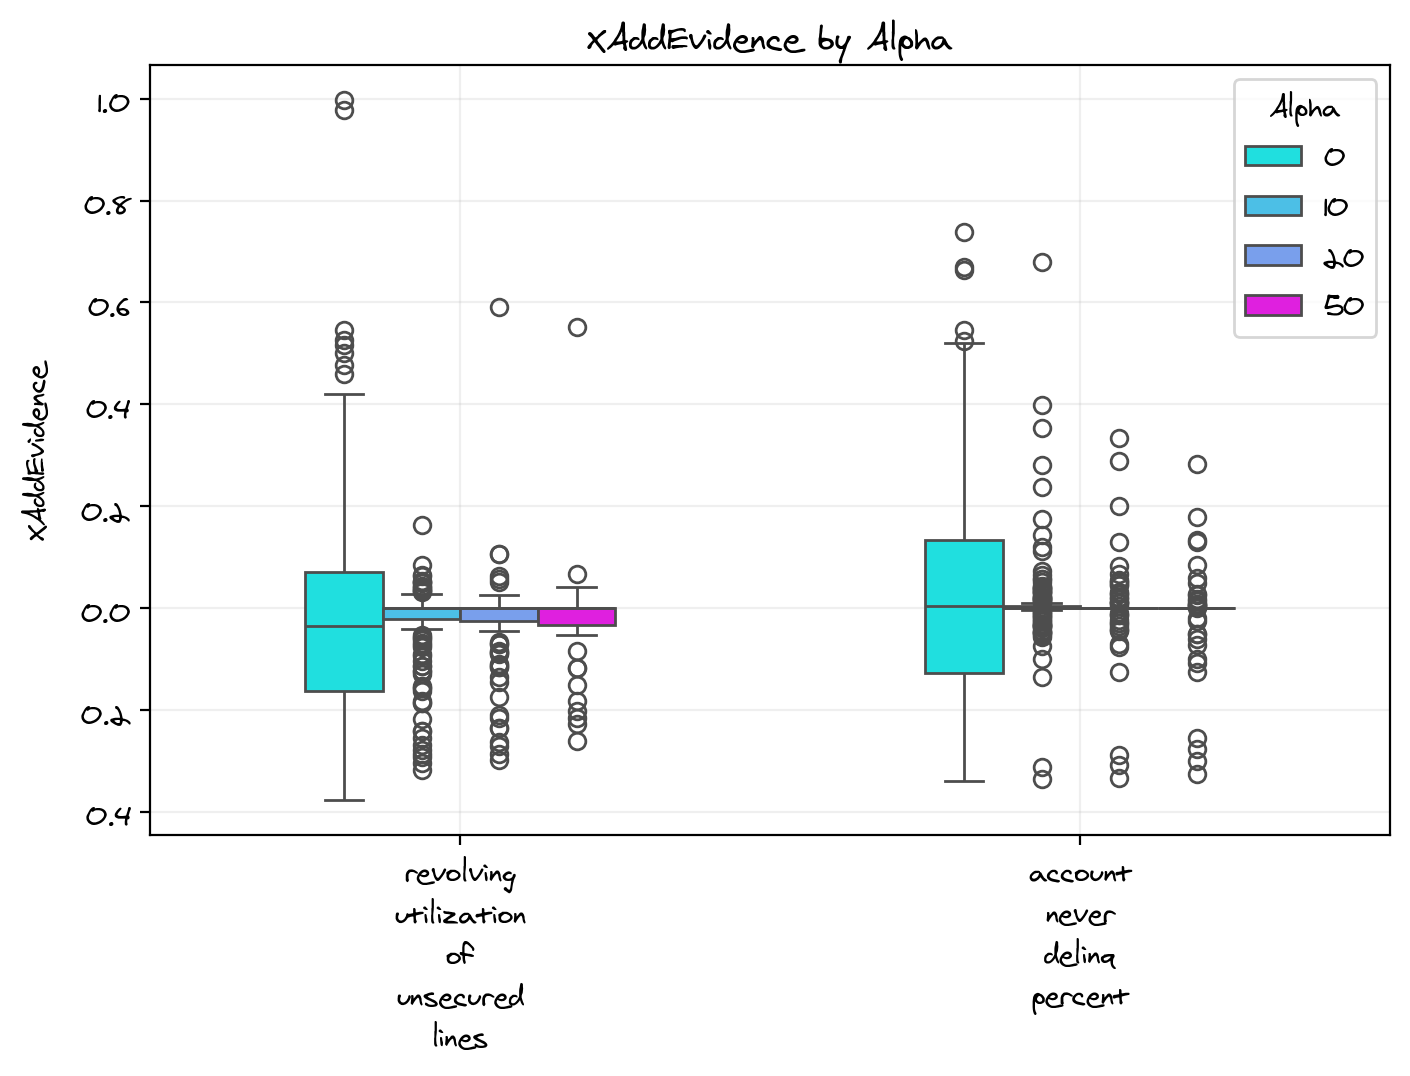

In [207]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Virgil GS"
%config InlineBackend.figure_format = 'retina'

# Create a boxplot to visualize feature gain distribution across Alpha values
plt.figure(figsize=(8, 5), dpi=100)
ax = sns.boxplot(
    data=df_leaf_weights_alpha,
    x="Feature",
    y="XAddEvidence",
    width=0.5,
    palette="cool",
    hue="Alpha",
)
plt.ylabel("XAddEvidence")
plt.xlabel(None)
plt.title("XAddEvidence by Alpha")
plt.legend(title="Alpha", loc="upper right")
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(
    [label.get_text().replace("_", "\n") for label in xticklabels],
    horizontalalignment="center",
)
plt.grid(alpha=0.2)
plt.show()

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_61350/1958311812.py:41: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()


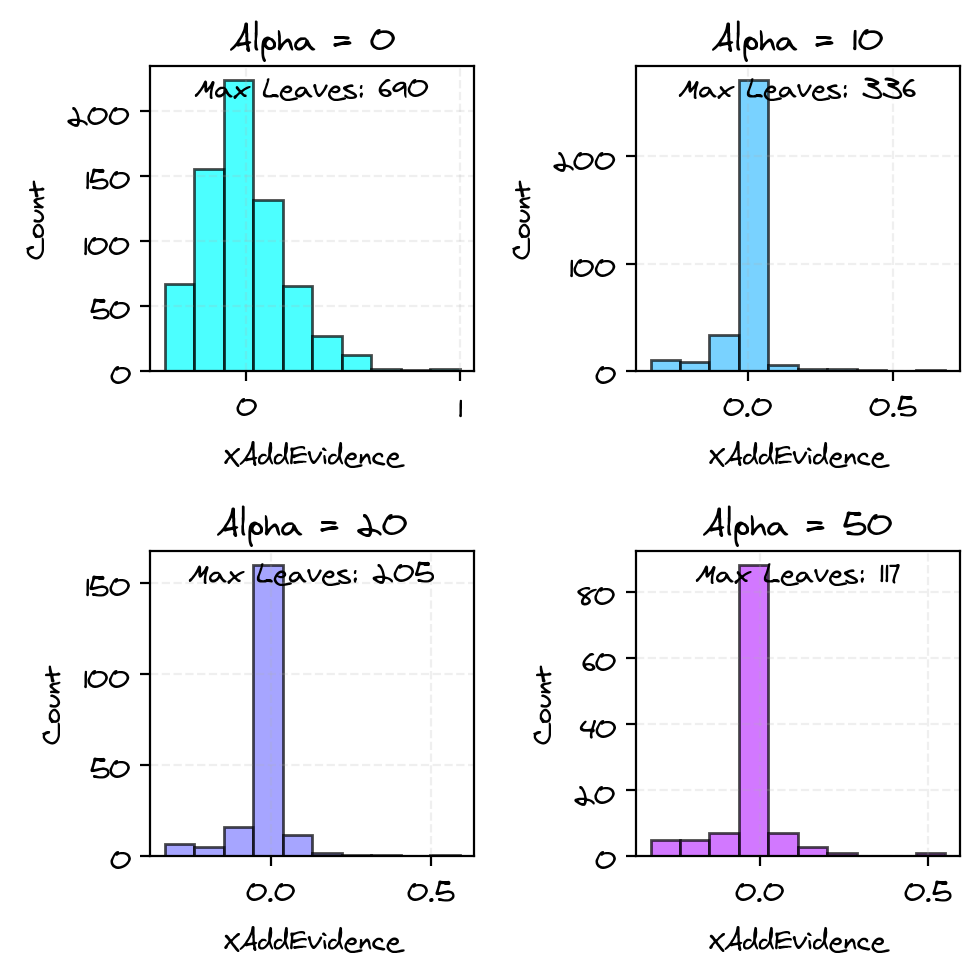

In [210]:
from matplotlib import pyplot as plt
import numpy as np

# Grouping the data by 'Alpha' and counting the occurrences of 'Feature'
leaf_count = df_leaf_weights_alpha.groupby("Alpha")["Feature"].count().reset_index()

# Set the number of columns and rows for subplots
num_cols = 2
num_rows = int(np.ceil(len(df_leaf_weights_alpha["Alpha"].unique()) / num_cols))

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5), sharex=False, dpi=100)

# Flatten the axes array to handle both 1-row and multi-row cases
axes = np.array(axes).flatten()

for i, (alpha_value, group) in enumerate(df_leaf_weights_alpha.groupby("Alpha")):
    ax = axes[i]
    ax.hist(
        group["XAddEvidence"],
        color=plt.get_cmap("cool")(i / len(df_leaf_weights_alpha["Alpha"].unique())),  # type: ignore
        alpha=0.7,
        bins=10,
        cumulative=False,
        rwidth=1.1,
        histtype="bar",
        edgecolor="black",
        # orientation='horizontal'
    )
    ax.set_title(f"Alpha = {alpha_value}")
    ax.set_xlabel("XAddEvidence")
    ax.set_ylabel("Count")

    # Add annotation with the count of leaves
    count = leaf_count.loc[leaf_count["Alpha"] == alpha_value, "Feature"].values[0]
    ax.annotate(
        f"Max Leaves: {count}", xy=(0.5, 0.9), xycoords="axes fraction", ha="center"
    )

    ax.grid(True, linestyle="--", alpha=0.2)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

plt.show()

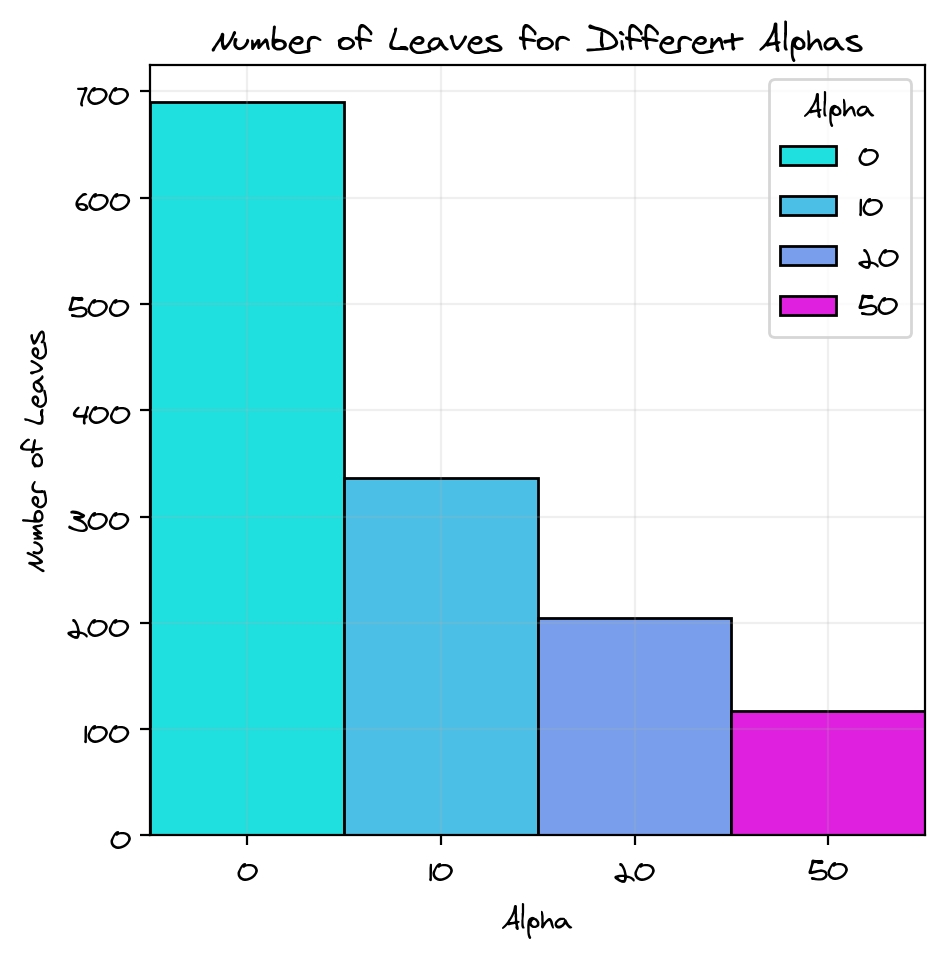

In [213]:
import seaborn as sns
from matplotlib import pyplot as plt

# Grouping the data by 'Alpha' and counting the occurrences of 'Leaf'
leaf_count = df_leaf_weights_alpha.groupby("Alpha")["Feature"].count().reset_index()

figure = plt.figure(figsize=(5, 5), dpi=100)
# Plotting the count of leaves for each 'Alpha'
sns.barplot(
    data=leaf_count,
    x="Alpha",
    y="Feature",
    palette="cool",
    hue="Alpha",
    edgecolor="black",
    width=1.0,
)
plt.xlabel("Alpha")
plt.ylabel("Number of Leaves")
plt.title("Number of Leaves for Different Alphas")
plt.grid(alpha=0.2)
plt.show()

In [203]:
df_leaf_weights_alpha[df_leaf_weights_alpha["XAddEvidence"] == 0].count()

Tree            189
Feature         189
Split           189
Sign            189
XAddEvidence    189
Alpha           189
dtype: int64

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Lambda</span>

L2 regularization term on weights. Increasing this value will make model more conservative. Normalised to number of training examples.

In [219]:
df_leaf_weights_lambda = pd.DataFrame()

for reg_lambda in [0, 10, 20, 50]:
    xgb_model = xgb.XGBClassifier(
        n_estimators=20,
        reg_lambda=reg_lambda,
        random_state=42,
    )
    xgb_model.fit(X.loc[ix_train], y.loc[ix_train])

    booster_ = xgb_model.get_booster()
    booster_dump = booster_.get_dump()

    df_leaf_weights = extract_leaf_weights(xgb_model)
    df_leaf_weights["Lambda"] = reg_lambda
    df_leaf_weights_lambda = pd.concat(
        [df_leaf_weights_lambda, df_leaf_weights], ignore_index=True
    )

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_61350/3051594324.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text().replace('_', '\n') for label in xticklabels], horizontalalignment='center')
/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


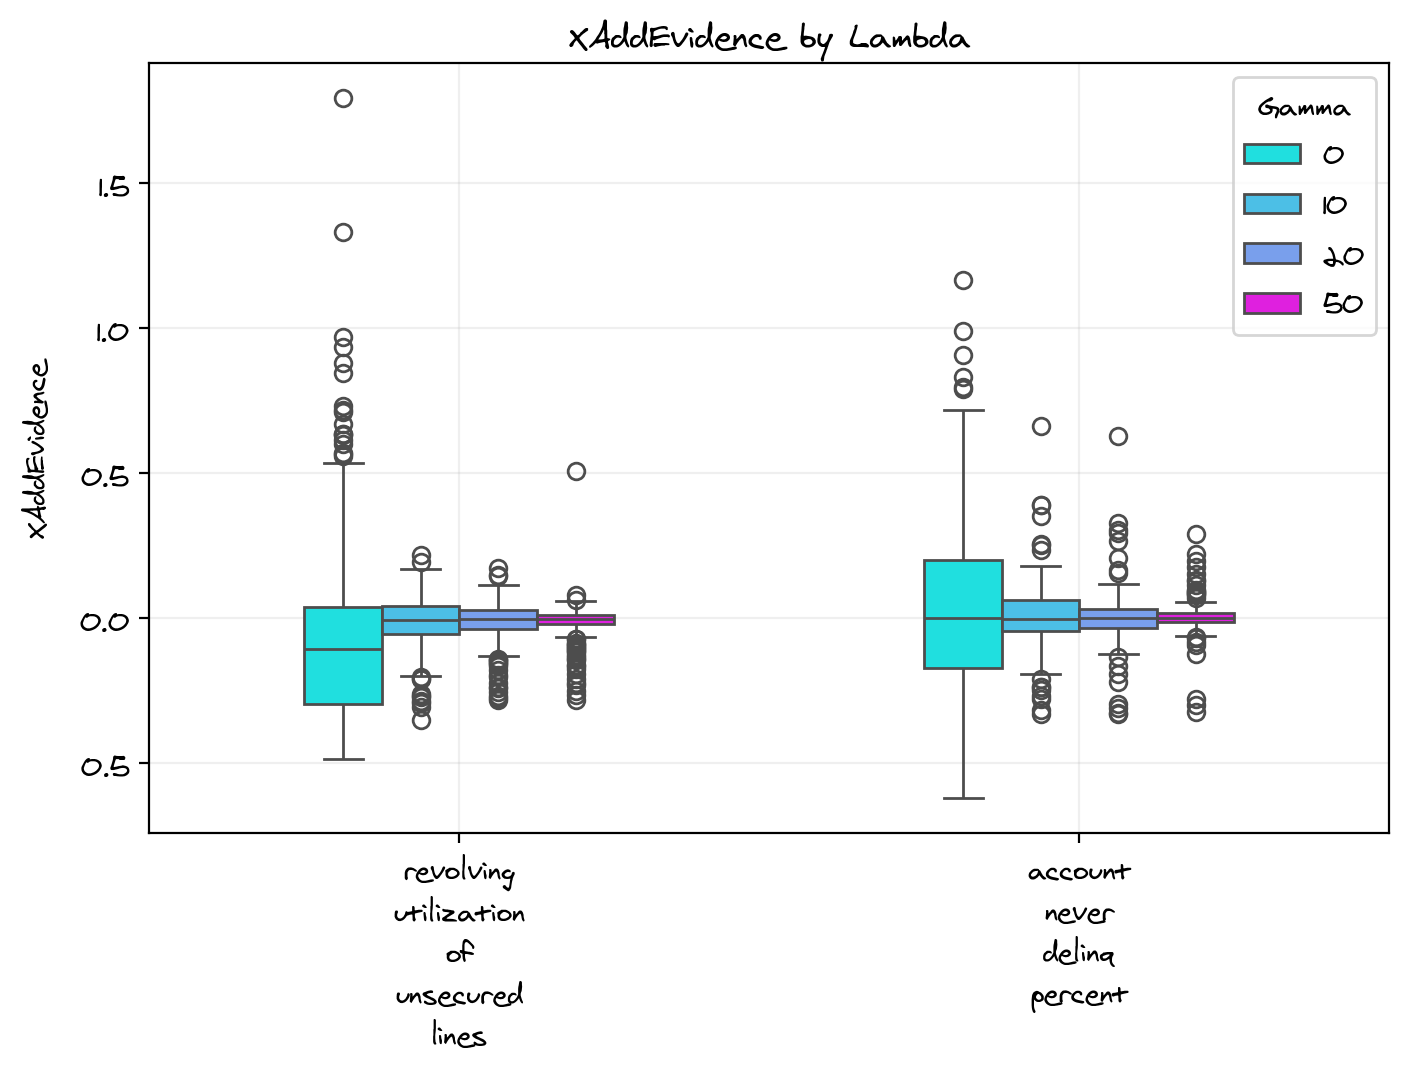

In [222]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Virgil GS"
%config InlineBackend.figure_format = 'retina'

# Create a boxplot to visualize feature gain distribution across Lambda values
plt.figure(figsize=(8, 5), dpi=100)
ax = sns.boxplot(
    data=df_leaf_weights_lambda,
    x="Feature",
    y="XAddEvidence",
    width=0.5,
    palette="cool",
    hue="Lambda",
)
plt.ylabel("XAddEvidence")
plt.xlabel(None)
plt.title("XAddEvidence by Lambda")
plt.legend(title="Gamma", loc="upper right")
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(
    [label.get_text().replace("_", "\n") for label in xticklabels],
    horizontalalignment="center",
)
plt.grid(alpha=0.2)
plt.show()

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_61350/1606936195.py:41: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()


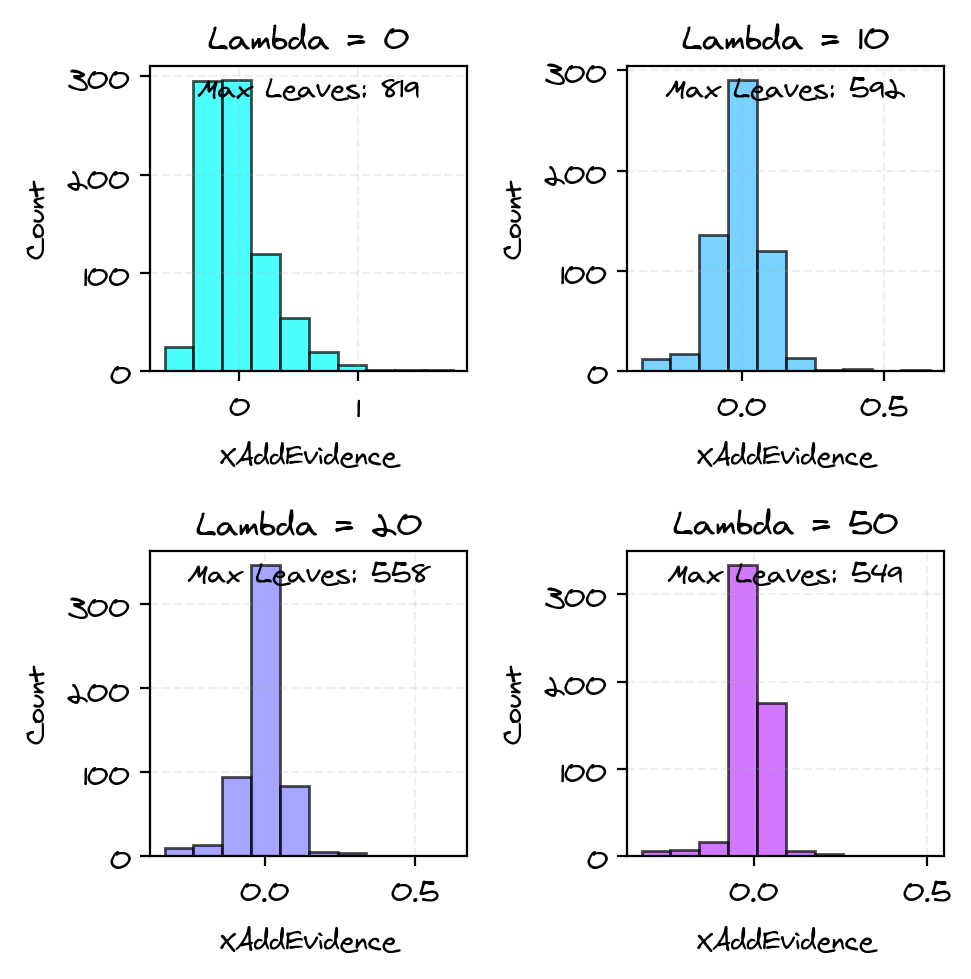

In [225]:
from matplotlib import pyplot as plt
import numpy as np

# Grouping the data by 'Lambda' and counting the occurrences of 'Feature'
leaf_count = df_leaf_weights_lambda.groupby("Lambda")["Feature"].count().reset_index()

# Set the number of columns and rows for subplots
num_cols = 2
num_rows = int(np.ceil(len(df_leaf_weights_lambda["Lambda"].unique()) / num_cols))

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5), sharex=False, dpi=100)

# Flatten the axes array to handle both 1-row and multi-row cases
axes = np.array(axes).flatten()

for i, (lambda_value, group) in enumerate(df_leaf_weights_lambda.groupby("Lambda")):
    ax = axes[i]
    ax.hist(
        group["XAddEvidence"],
        color=plt.get_cmap("cool")(i / len(df_leaf_weights_lambda["Lambda"].unique())),  # type: ignore
        alpha=0.7,
        bins=10,
        cumulative=False,
        rwidth=1.1,
        histtype="bar",
        edgecolor="black",
        # orientation='horizontal'
    )
    ax.set_title(f"Lambda = {lambda_value}")
    ax.set_xlabel("XAddEvidence")
    ax.set_ylabel("Count")

    # Add annotation with the count of leaves
    count = leaf_count.loc[leaf_count["Lambda"] == lambda_value, "Feature"].values[0]
    ax.annotate(
        f"Max Leaves: {count}", xy=(0.5, 0.9), xycoords="axes fraction", ha="center"
    )

    ax.grid(True, linestyle="--", alpha=0.2)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

plt.show()

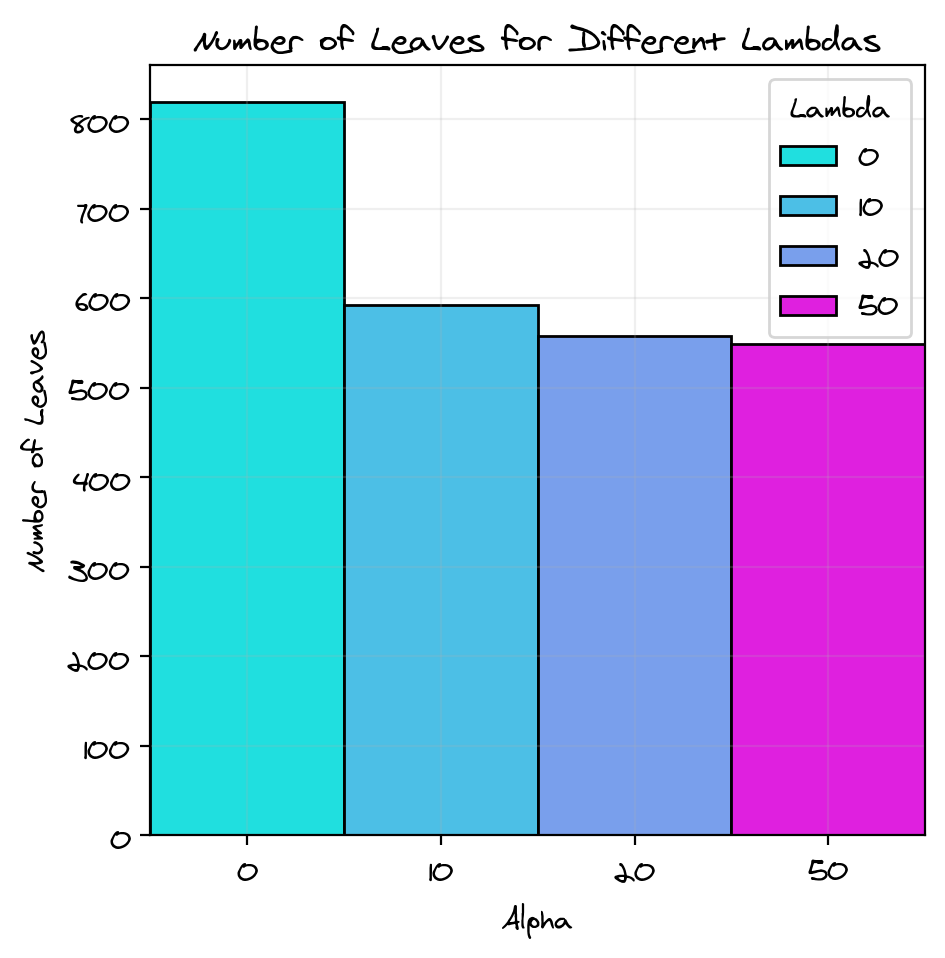

In [228]:
import seaborn as sns
from matplotlib import pyplot as plt

# Grouping the data by 'Lambda' and counting the occurrences of 'Leaf'
leaf_count = df_leaf_weights_lambda.groupby("Lambda")["Feature"].count().reset_index()

figure = plt.figure(figsize=(5, 5), dpi=100)
# Plotting the count of leaves for each 'Lambda'
sns.barplot(
    data=leaf_count,
    x="Lambda",
    y="Feature",
    palette="cool",
    hue="Lambda",
    edgecolor="black",
    width=1.0,
)
plt.xlabel("Alpha")
plt.ylabel("Number of Leaves")
plt.title("Number of Leaves for Different Lambdas")
plt.grid(alpha=0.2)
plt.show()